In [237]:
import numpy as np 
import matplotlib.pyplot as plt

In [238]:
#Simulation inputs

# Constants
T = 298 # Temperature [K]
F = 96485 # Faraday’s constant [C/mol]
R = 8.3145 # Gas constant [(C*V)/(mol*K)]
f = F/(R*T) # Reduced electrochemical parameter
Cox = 1.0 #  initial concentration of Ox [M]
D = 1E-6 # Diffusion coefficient [cm^2/s] {default: 1E-6}
v = 80*1E-3 # Scan rate [V/s] {default: 1E-3}
n = 1.0  # Number of electrons transferred during reaction {default: 1}
alpha = 0.5  # Transfer coefficient (unitless) {default: 0.5}
k0 = .5*1E-3 # Heterogeneous rate constant [m/s] {default: 1E-1}
kc = 1E-3 # Chemical rate constant [m/s] {default: 1E-3}

# Simulation Paramterers 
L = 500 # Number of time steps {default: 500}
DM = 0.45 # Model diffusion coefficient from problem. Default = 0.45
eta0 = 0.8 # Initial overpotential (relative to redox) [V] {default: 0.2}
etaF = -0.8 # Final overpotential (relative to redox) [V] {default: -0.2}

# Time paramaters 
ti = np.array(list(range(0,L))) # time index vector
total_t  = 2*(eta0-etaF)/v # Maximum t value to simulate (1 CV)
del_t  = total_t/L # Time interval
t = del_t * ti # Discretized t
tset1 = t[0:250]
tset2 = t[250:]

# Kinetic parameters
ktk = kc*total_t   # Dimensionless kinetic parameter 
km = ktk/L # Normalized Dimensionless Kinetic parameter
Lambda = k0/(D*f*v)**(0.5)  # Dimensionless Reversibility Parameter
psi = 20 # Dimensionless Reversibility Parameter
k0 = psi * np.sqrt((D*f*v)/np.pi) # Heterogeneous rate constant [m/s] {default: dependent on psi parameter}

# Mesh Point Parameters
del_x  = np.sqrt(D*del_t/DM) # x interval
npts_x = 100  # Number of mesh points {default: 100}
k0

0.019916074975612735

In [239]:
# Initial Setup and Time Step
Cox= Cox / 1000 # Convert C from mol/L to mol/cm3
eta1 = list(eta0 - v * tset1) # overpotential vector, negative scan
# eta2 = list(etaF + v * tset2) # overpotential vector, positive scan
eta2 = list(reversed(eta1))
eta = np.asarray(eta1 + eta2) # Overpotential scan values [V] 

Enorm = eta * f # normalized overpotential
kf = k0 *np.exp(-alpha * n * Enorm) # [=] cm/s, fwd rate constant (pg 799)
kb = k0 *np.exp((1-alpha) * n * Enorm) # [=] cm/s, rev rate constant (pg 799)

Cox_x = Cox*np.ones((L+1,npts_x)) # [=] mol/cm^3, concentration of Cox_x
Cred_x = np.zeros((L+1,npts_x))  # [=] mol/cm^3, concentration of Cred_x
Flux = np.zeros((1,L+1)) # [=] mol/cm^2-s, flux of Cox_x at the surface
Z = np.ones((1,L+1))

In [240]:
# Run Simulation
# j = time index. i = distance index
for j in range (1,L-1):
    # Update bulk concentrations of Cox_x and Cred_x
    for i in range(1,npts_x-1):
        Cox_x[j+1,i] = Cox_x[j,i] + DM*(Cox_x[j,i+1]+Cox_x[j,i-1]-2*Cox_x[j,i])
        Cred_x[j+1,i] = Cred_x[j,i] + DM*(Cred_x[j,i+1]+Cred_x[j,i-1]-2*Cred_x[j,i]) - km * Cred_x[j,i]

    if j == L:
        Flux[j] = Flux[j-1]
    else:
        # Update flux
        Flux[0,j+1] = (kf[j+1] * Cox_x[j+1,1] - kb[j+1] * Cred_x[j+1,1]) / (1 + del_x/D*(kf[j+1] + kb[j+1]))
    # Update surface concentrations
    Cox_x[j+1,0] = Cox_x[j+1,2] - Flux[0,j+1]*(del_x/D)
    Cred_x[j+1,0] = Cred_x[j+1,2] + Flux[0,j+1]*(del_x/D) - km*Cred_x[j+1,1]

# Calculate current density, Z, from flux of Cox_x
Z = -n *F * Flux * 1000 # [=] A/cm^2 -> mA/cm^2, current density

inminvolt = np.argmin(Z[0])
inmaxvolt = np.argmax(Z[0])
Epp = eta[inmaxvolt] - eta[inminvolt]
Epp

0.10240000000000005

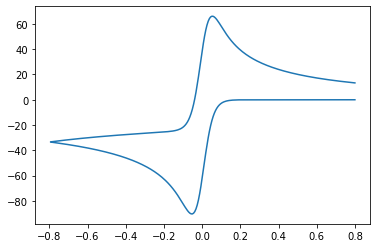

In [241]:
tlist = np.asarray(t)
Zlist = Z.flatten()
Znew = Zlist[0:-1]
plt.plot(eta,Znew)